In [ ]:
# Descarga de archivos de ProfNER
!wget https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip  profner.zip?download=1

--2023-07-05 15:18:36--  https://zenodo.org/record/4563995/files/profner.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46552748 (44M) [application/octet-stream]
Saving to: ‘profner.zip?download=1.4’

profner.zip?downloa 100%[===================>]  44.40M  3.12MB/s    in 40s     

2023-07-05 15:19:17 (1.12 MB/s) - ‘profner.zip?download=1.4’ saved [46552748/46552748]

Archive:  profner.zip?download=1
replace profner/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Funciones de carga y preparación de datos

In [ ]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt
    que se introduce en su entrada.
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()

  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Ejercicio


En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Específicamente, se utilizarán los datos textuales de la subtarea 1, centrada en la clasificación de textos. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Por si fuera de tu interés, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

Para el ejercicio debéis entrenar diferentes modelos de clasificación que permitan clasificar correctamente los tweets. Para ello será necesario crear y utilizar funciones de preprocesado de datos similares a las vistas en clase, aplicar estrategias de vectorización de trextos como TF-IDF o embeddings, y entrenar/evaluar modelos de clasificación. Para que os sirva de orientación, los criterios de evaluación del ejercicio serán los siguientes:

-	**Análisis exploratorio, pre-procesado y normalización de los datos (30%)**:
        -	El ejercicio deberá contener un análisis exploratorio de los datos como número de documentos, gráficas de distribución de longitudes y/o wordclouds, entre otros análisis que se os pudieran ocurrir. Vuestros ejercicios deberán incorporar al menos los análisis exploratorios vistos en clase.

    -	También tendréis que tener funciones para normalizar textos que permitan eliminar palabras vacías, quitar símbolos de puntuación y lematizar o hacer stemming.  

-	**Vectorización de textos (40%)**

    En clase hemos visto diferentes estrategias de vectorización como TF-IDF y Word Embeddings. También hemos visto como incorporar características adicionales utilizando el sentimiento de los documentos. Para este ejercicio sois libres de utilizar la estrategia de vectorización que queráis, pero:
  -	Si decidís utilizar TF-IDF será necesarios que incorporéis a modelo características adicionales de sentimiento utilizando recursos adicionales (como por ejemplo la librería TextBlob).
  -	Si optáis por representar el texto mediante embeddings, dado que en clase no se profundizado sobre el tema no será necesario incorporar esas características adicionales. Si decidís esta segunda opción, podéis utilizar los embeddings en español que vimos en clase

-	**Entrenamiento y validación del sistema (30%)**
  -	En el proceso de entrenamiento del modelo tendréis que testear al menos 3 modelos de clasificación. El procedimiento debe ser similar al visto en clase, en el que primero estimábamos el rendimiento de varios algoritmos de forma general, para posteriormente seleccionar el mejor para ajustar los hiperparámetros.


## 0. Imports


In [ ]:
# Instalamos nltk
!pip install nltk
# Importamos
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('omw-1.4')

# Instalamos textacy
!pip install textacy
# Instalamos spacy y uno de sus modelos
!pip install spacy

# Descargamos el modelo pre-entrenados de spacy español
!python -m spacy download es_core_news_sm


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import string



## 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [ ]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)


In [ ]:
datos_ejercicio.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


## 2. Análisis exploratorio

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Sacamos el numero de documentos
num_docs = len(datos_ejercicio)
print(f'Número de documentos: {num_docs}')

Número de documentos: 8000


Longitud media de los documentos: 30.17


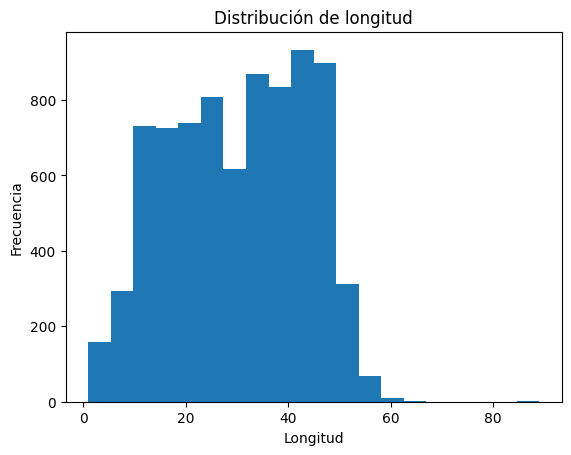

In [ ]:
# Estamos analizando tweets, por lo que la longitud no será demasiado larga, vamos a ver la longitud media
datos_ejercicio['doc_length'] = datos_ejercicio['tweet_text'].apply(lambda x: len(x.split()))
mean_length = datos_ejercicio['doc_length'].mean()
print(f'Longitud media de los documentos: {mean_length:.2f}')

# Para que sea un poco más visual vamos a ver un gráfico de distribución de la longitud
plt.hist(datos_ejercicio['doc_length'], bins=20)
plt.title('Distribución de longitud')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

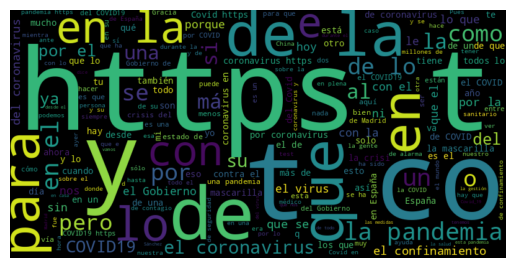

In [ ]:
# Como vimos en clase, utilizar worldcloud es una forma muy visual de analizar laas palabras utilizadas
text = ' '.join(datos_ejercicio['tweet_text'])
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Como se puede observar, muchas de las palabras que se repiten son preposiciones, que no nos aportan mucho contexto realmente, así que voy a excluirlas del wordCloud, al igual que 'https' para ver un analisis mas preciso y que algunas otras palabras como 'el', 'que', 'las'...

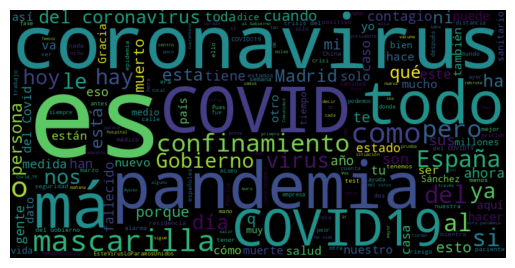

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Lista de palabras a excluir
stopwords = set(STOPWORDS)
stopwords.update(['https', 'a', 'ante', 'bajo', 'con', 'contra', 'de', 'desde', 'durante', 'en', 'entre', 'hacia', 'hasta', 'mediant', 'para', 'por', 'pro', 'según', 'sin', 'sobre', 'tras', 'vía', 'lo', 'las', 'los', 'la', 'co', 't', 'y', 'su', 'un', 'una', 'que', 'el', 'e', 'se'])

# Crear el wordcloud
text = ' '.join(datos_ejercicio['tweet_text'])
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ahora si podemos ver un wordCloud mucho más descriptivo. Hay un claro patrón de temática alrededor del covid 19

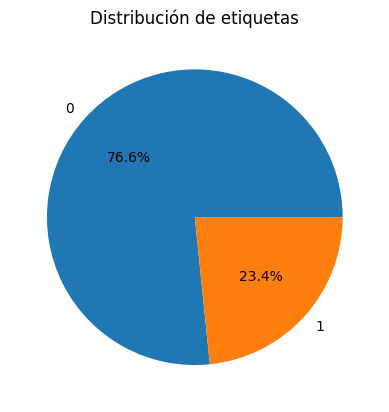

In [ ]:
# Ahora vamos a ver la frecuencia de la etiqueta 1 o 0 de menciones de profesiones en el tweet
label_freq = datos_ejercicio['label'].value_counts()

# Creamos un pie chart para visualizarlo
plt.pie(label_freq, labels=label_freq.index, autopct='%1.1f%%')
plt.title('Distribución de etiquetas')
plt.show()

## 3. Preprocesado y Normalización

Vamos a normalizar los datos:

In [10]:
# Eliminar espacios
def eliminar_espacios(text):
    return  " ".join(text.split())

# Tokenizador
from nltk import word_tokenize
def tokenization(text):
  tokens = nltk.word_tokenize(text)
  return tokens

# Reemplazar contractions usando la librería "contractions" https://github.com/kootenpv/contractions
def replace_contraction(text):
    expanded_words = []
    for t in text.split():
        expanded_words.append(contractions.fix(t))
    expanded_text = ' '.join(expanded_words)
    return expanded_text

# Quitar palabras vacias en espanol
from nltk.corpus import stopwords
def quitar_stopwords(tokens):
    stop_words = set(stopwords.words('spanish'))
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence


# Eliminar signos de puntuación
def quitar_puntuacion(tokens):
    words=[word for word in tokens if word.isalnum()]
    return words


# Lemmatización
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lematizar(tokens):
    sentence = " ".join(tokens)
    mytokens = nlp(sentence)
    # Lematizamos los tokens y los convertimos  a minusculas
    mytokens = [ word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Extraemos el text en una string
    return " ".join(mytokens)


import string
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stem(tokens):
    tokens = [ stemmer.stem(token) for token in tokens]
    return tokens

## 4. Vectorización

A la hora de la vectorización se nos han ofrecido dos opciones, y aunque Embedding pueda tener mejor rendimiento en el procesado de lenguaje natural, he decidido optar por TF-IDF, ya que va a ser más óptimo a la hora de recursos y entrenamiento. TextBlob nos permite usar analizadores, en concreto usarmos PatternAnalyzer porque es relativamente rápido y para un dataset de nuestro tamaño será óptimo.

In [11]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(datos_ejercicio['tweet_text'])

#Con los datos transformados obtenemos los nombres
feature_names = vectorizer.get_feature_names_out() if hasattr(vectorizer, 'get_feature_names_out') else vectorizer.get_feature_names()

#Creamos el dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

#Implementamos TextBlob
sentiments = datos_ejercicio['tweet_text'].apply(lambda x: TextBlob(x, analyzer=PatternAnalyzer()).sentiment)

#Metemos las características de sentimiento al sataframe
tfidf_df['sentiment_polarity'] = sentiments.apply(lambda x: x.polarity)
tfidf_df['sentiment_subjectivity'] = sentiments.apply(lambda x: x.subjectivity)


## 5. Entrenamiento y evaluación de modelos


In [13]:
# Importamos numpy:
import numpy as np

# Definimos la variable de categorías:
y = datos_ejercicio['label']

print(y.shape)

(8000,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y , random_state=0)
print(X_train.shape)
print(X_test.shape)

(6000, 32624)
(2000, 32624)


In [15]:
# Definimos las funcionalidades pertinentes de sklearn:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
# Definimos la función encargada de evaluar los modelos:
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #PAra cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Generamos un Kfold
          KF = KFold(n_splits = 10, shuffle = True, random_state = 98)

          # hacemos croos_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardamos los resultados:
          results.append(cv_results)
          names.append(name)

          # Mostramos los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return results, names

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
models = [
         ("Logistic",LogisticRegression(random_state=30)),
         ("GaussianNB",GaussianNB()),
         ("Decision Tree", DecisionTreeClassifier())
]
evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, tfidf_matrix.toarray(), y)

Metric: accuracy , KFold 
Logistic: 0.807500 (0.016115) 
Metric: accuracy , KFold 
GaussianNB: 0.617125 (0.010754) 


KeyboardInterrupt: ignored

Despues de evaluar varios modelos, nos vamos a quedar con el regresor logístico

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [19]:
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = KFold(n_splits=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [20]:
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.856000 usando los parámetros {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [21]:
from sklearn.model_selection import (KFold, cross_val_score,cross_validate)
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model=LogisticRegression(C=100, penalty="l2", solver = "liblinear")
model.fit(X_train,y_train)

LogisticRegression(C=100, solver='liblinear')

In [22]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[1508   35]
 [ 230  227]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1543
           1       0.87      0.50      0.63       457

    accuracy                           0.87      2000
   macro avg       0.87      0.74      0.78      2000
weighted avg       0.87      0.87      0.85      2000



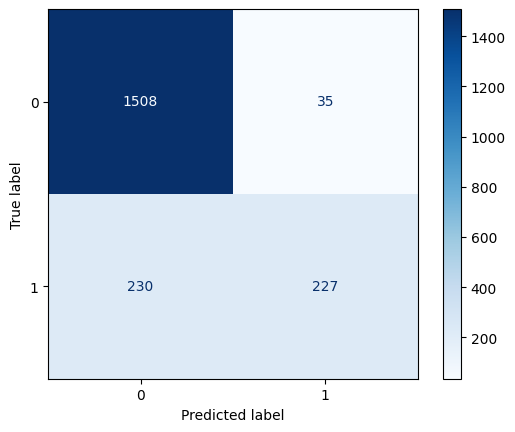

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize = None, cmap= 'Blues')